# Creating the dataset

In [1]:
import torch
from torch import nn
import pandas as pd
from PIL import Image
import numpy as np
import random
from sklearn.model_selection import train_test_split
import random
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from pathlib import Path

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

# Creating a dataframe to extract the data
df = pd.read_csv('data/train.csv')

# Creating the dataset and split it in train and test
X, y = np.array(df.loc[:, ~df.columns.isin(['label'])]), np.array(df['label'])
X, y = torch.tensor(X).type(torch.float), torch.tensor(y).type(torch.LongTensor)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

Using cuda device


# Data Loader

In [2]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        x = self.X[index]
        y = self.y[index]

        return x, y


train_dataset = Data(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Vizualizing the images

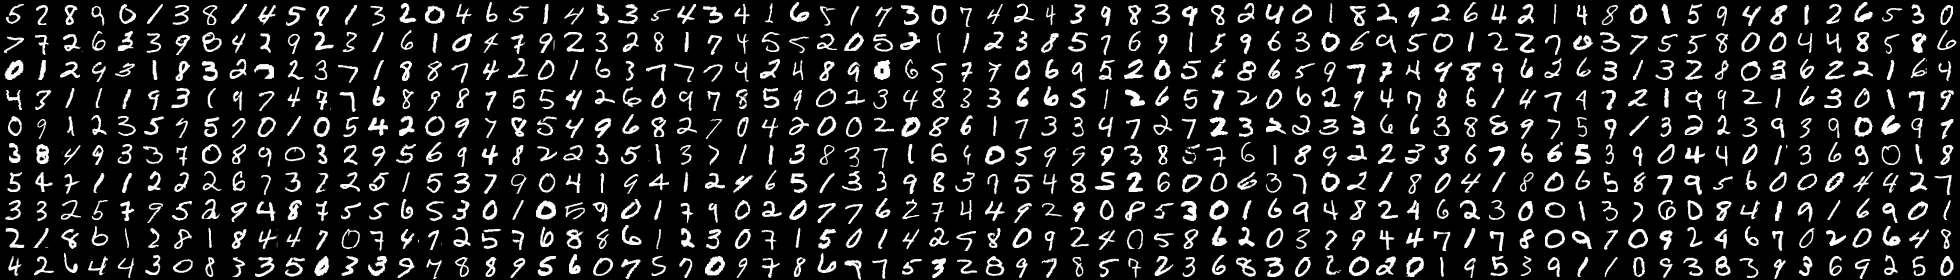

In [3]:
imgs = np.array(df.loc[:, ~df.columns.isin(['label'])])

# Defining the size of the matrix of numbers
MATRIX_WIDTH = 70
MATRIX_HEIGHT = 10

# The size of each image
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28

# Creates the matrix
matrix = Image.new('L', (MATRIX_WIDTH * IMAGE_WIDTH, MATRIX_HEIGHT * IMAGE_HEIGHT))

# Put random images in the matrix
for i in range(MATRIX_HEIGHT):
    for j in range(MATRIX_WIDTH):
        image = Image.fromarray(imgs[random.randint(0, len(X))].reshape(28, 28).astype('uint8'), mode='L')
        x = j * IMAGE_WIDTH
        y = i * IMAGE_HEIGHT
        matrix.paste(image, (x, y))

display(matrix)

# The model

In [4]:
class MNIST(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.sequence = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 10)
        )

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.sequence(X)

model = MNIST().to(device)
display(model)

MNIST(
  (sequence): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=32, out_features=10, bias=True)
  )
)

# Defining some hyperparameters

In [5]:
# Calculate the accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optmizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.00001)

# Training

In [6]:
epochs = 75
acc = []
error = []

for epoch in range(epochs):
    for X, y in train_loader:
        ### Train
        model.train()

        # 1. Forward
        pred = model(X)

        # 2. Loss
        loss = loss_fn(pred, y)

        # 3. Backward
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


        ### Testing
        model.eval()
        with torch.inference_mode():
            test_preds = torch.softmax(model(X_test), dim=1).argmax(dim=1)
            test_acc = accuracy_fn(y_test, test_preds)
    
    error.append(loss.item())
    acc.append(test_acc / 100)
    if epoch % 5 == 0:
        print('Epoch: {:<5d}    | Loss: {:<.10f}    | Acc: {:.2f}%'.format(epoch, loss, test_acc))

Epoch: 0        | Loss: 0.5446810722    | Acc: 87.38%
Epoch: 5        | Loss: 0.1390585154    | Acc: 94.89%
Epoch: 10       | Loss: 0.0821102485    | Acc: 95.93%
Epoch: 15       | Loss: 0.0394030735    | Acc: 96.55%
Epoch: 20       | Loss: 0.0289145187    | Acc: 96.87%
Epoch: 25       | Loss: 0.0172896348    | Acc: 96.90%
Epoch: 30       | Loss: 0.0088494942    | Acc: 97.17%
Epoch: 35       | Loss: 0.0090572638    | Acc: 97.07%
Epoch: 40       | Loss: 0.0024604476    | Acc: 97.18%
Epoch: 45       | Loss: 0.0018794695    | Acc: 97.31%
Epoch: 50       | Loss: 0.0010590649    | Acc: 97.44%
Epoch: 55       | Loss: 0.0027414772    | Acc: 97.49%
Epoch: 60       | Loss: 0.0009249366    | Acc: 97.42%
Epoch: 65       | Loss: 0.0003118389    | Acc: 97.44%
Epoch: 70       | Loss: 0.0000306580    | Acc: 97.40%


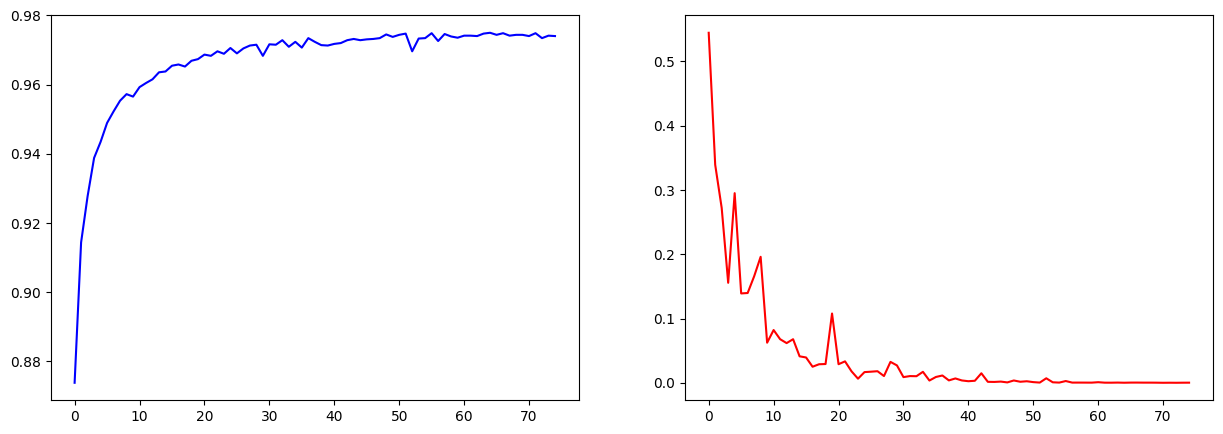

In [17]:
# Criar a figura e os subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

# Accuracy graphic
ax1.plot(acc, label='Accuracy', color='blue')

fig.set_size_inches(15, 5)  # Largura: 10 polegadas, Altura: 5 polegadas

# Loss graphic
ax2.plot(error, label='Loss', color='red')

# Exibir o gráfico
plt.show()



# Saving the model

In [19]:
# create models directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# create model save path
MODEL_NAME = 'MNIST_v0'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
MODEL_SAVE_PATH

# save the model
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

# Preditions

In [34]:
model.eval()
with torch.inference_mode():
    y_logits = model(X_test)
    a = random.randint(0, len(X_test))
    b = a + 10

    # Prediction
    pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    pred = pred[a:b].tolist()

    # Correct labels
    labels = y_test[a:b].tolist()

print('Predictions:  ', pred)
print('Labels:       ', labels)

pred = torch.tensor(pred)
labels = torch.tensor(labels)
print(f'\nCorrects: {torch.eq(pred, labels).sum().item()} in 10')

Predictions:   [3, 2, 9, 2, 9, 9, 9, 2, 4, 3]
Labels:        [3, 2, 9, 2, 9, 9, 9, 2, 4, 3]

Corrects: 10 in 10
